# Homework 3 Submission
## Yonadav Shavit

In [617]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.special import factorial
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1

### (a)

Proving that this mechanism is $\epsilon$-DP is equivalent to proving that the trimmed mean calculation has global sensitivity $GS = \frac{D}{0.9n}$, because then the injected Laplace noise would ensure compliance.

The maximum change caused by a single element changing would be a change from $0$ to $D$ (w.l.o.g.) - which would if the bottom 94.99...% were 0s, and the top 5.00...01% were $D$s, would cause an overall change of $\frac{D}{0.9n}.$

In [618]:
def lap_mechanism(epsilon, GS_q, size=None):
    return np.random.laplace(scale=GS_q/epsilon, size=size)

def dp_mean(x, epsilon, b, a=0):
    x_clipped = np.clip(x, a, b)
    GS_q = np.abs(b-a)/x.shape[0]
    return x_clipped.mean() + lap_mechanism(epsilon, GS_q)

def trimmed_mean(x, epsilon, D, upper=0.95, lower=0.05):
    n = x.shape[0]
    x_sorted = np.sort(x)
    x_trimmed = x_sorted[int(n*lower):int(n*upper)]
    GS_q = D/(0.9*n)
    return (1/((upper - lower)*n))*np.sum(x_trimmed) + lap_mechanism(epsilon, GS_q)

## (b)
The winsorized mean is not $\epsilon$-DP because the global sensitivity can, in certain cases, be much greater than $\frac{D}{n}$.

Say we have a dataset where the bottom 95.00...01% are $0$s and the top 4.99...% are $D$s (such that $P_{0.95} = 0$).
Now, we switch a single $0$ to $D$, and suddenly $P_{0.95} = D$. This means that the overall mean calculation changes by $\frac{D \times 0.05n}{n} = .05D$.
If $\frac{D}{n} = GS_q < .05D$, i.e. $n>20$, this violates $\epsilon$-DP.

## (c)
The utility function for the exponential mechanism for $p_t$ would be:
$$ u_t(x, y) = \min \{ \frac{100-t}{100} \left(\#\{ i: x_i \leq y\}\right), \frac{t}{100}\left(\#\{ i: x_i \geq y\}\right)\}$$

In [619]:
def pct_dp(x, t, epsilon):
    x = np.sort(x)
    n = x.shape[0]
    x_inds = np.arange(0, n)

    # NOTE: we use x > val and x < val rather than >= and <= because, other than the precise value, 
    # all the responses in the surrounding interval don't satisfy equality
    lower = (1 - t/100)*(x_inds + 1) # everything up to the current interval start inclusive
    upper = t/100      *(n - (x_inds + 1)) # everything from the current interval start exclusive
    u = np.minimum(lower, upper)
    u = u[:-1] # remove last element, which will definitely have probability 0

    overflow_offset = np.max(epsilon*u)
    exp_u = np.exp(epsilon*u - overflow_offset)
    w = np.array([x[i+1] - x[i] for i in x_inds[:-1]])
    p_raw = w*exp_u
    p = p_raw/np.sum(p_raw)
#     print(f"u:{u}\n exp_u:{exp_u}\n p_raw:{p_raw}\n p:{p}")
    interval_i = np.random.choice(x_inds[:-1], p=p)
    return np.random.uniform(x[interval_i], x[interval_i + 1])

## (d)

In [620]:
def trimmed_mean_dp_bounds(x, epsilon, b):
    n = x.shape[0]
    x = np.sort(x)
    p05 = pct_dp(x, 5, epsilon/3)
    p05_ind = np.argmax((x>=p05))
    p95 = pct_dp(x, 95, epsilon/3)
    p95_ind = np.argmax(x>=p95)
    x_trimmed = x[p05_ind:p95_ind]
    GS_q = (p95 - p05)/(0.9*n)
#     print(p95 - np.percentile(x, 95), p05 - np.percentile(x, 5))
#     print(0.9*n, p95_ind - p05_ind)
          
    return (1/(0.9*n))*np.sum(x_trimmed) + lap_mechanism(epsilon/3, GS_q)

In [624]:
x = np.random.random(size=1000)
epsilon = 1
# print(pct_dp(x, 95, epsilon/3))
print(trimmed_mean_dp_bounds(x, epsilon, 10))

0.49921794143479653


## (e)
This method actually seems to be differentially private, because a single input changing can no longer guaranteedly change the winsorization boundaries ($p_{.95}$ or $p_{.05}$).
If a single element cannot substantially change the boundaries, then by that same logic it should have little impact on the $\frac{n}{20}$ elements clamped to that value. Instead, its impact will primarily be felt as a single element change in the sum, which has bounded sensitivity $\frac{P_{95} - P_{05}}{n}$.


## (f)


In [625]:
df = pd.read_csv("../data/MaPUMS5full.csv")
df.describe()
puma_block_incomes = {puma_:df.income[df.puma == puma_].values for puma_ in df.puma.unique()}

In [626]:
D = 1e6
eps = 1
trials = 100
mean_types = ["normal", "trimmed", "true"]
mean_algs = {
    "true": lambda x, epsilon, b: np.mean(x),
    "normal": dp_mean,
    "trimmed": trimmed_mean_dp_bounds,
}
pumas = list(df.puma.unique())
puma_means = {t:{} for t in mean_types}
for puma_, puma_block in tqdm_notebook(puma_block_incomes.items()):
    x = np.sort(puma_block)
    for t in mean_types:
        ms = [mean_algs[t](x=x, epsilon=eps, b=D) for _ in range(trials)]
        puma_means[t][puma_] = ms

In [633]:
# Let's calculate the RMSE:
rmse_lap = np.mean((np.array(list(puma_means['normal'].values())) -
                    np.array(list(puma_means['true'].values())))**2)
rmse_trimmed = np.mean((np.array(list(puma_means['trimmed'].values())) -
                        np.array(list(puma_means['true'].values())))**2)
print(f"RMSE for Laplace Mechanism: {rmse_lap}")
print(f"RMSE for Trimming Mechanism: {rmse_trimmed}")

RMSE for Laplace Mechanism: 109426.60408923356
RMSE for Trimming Mechanism: 57244680.08714796


This disparity is enormous because the Trimming mechanism (likely due to a bug) consistently underestimated the mean. This is discussed further later.

In [634]:
puma_by_mean = [(puma_means["true"][puma_][0], puma_) for puma_ in pumas]
pumas_sorted = [p[1] for p in sorted(puma_by_mean)]

In [635]:
results_df = pd.DataFrame(columns=['type_', 'puma_', 'mean'])
for type_ in ["normal", "trimmed", "true"]:
# for type_ in ["normal"]:
#     for puma_ in pumas_sorted:
    for i, puma_ in enumerate(pumas_sorted[:20]):
        results_df = results_df.append(
            pd.DataFrame(
                np.stack([np.array([type_]*trials),
                          np.array([i]*trials),
                          puma_means[type_][puma_]],
                         axis=-1
                        ),
                columns=['type_', 'puma_', 'mean']),
        ) 
results_df = results_df.astype({
    'type_': str,
    'puma_': int,
    'mean': float,
})

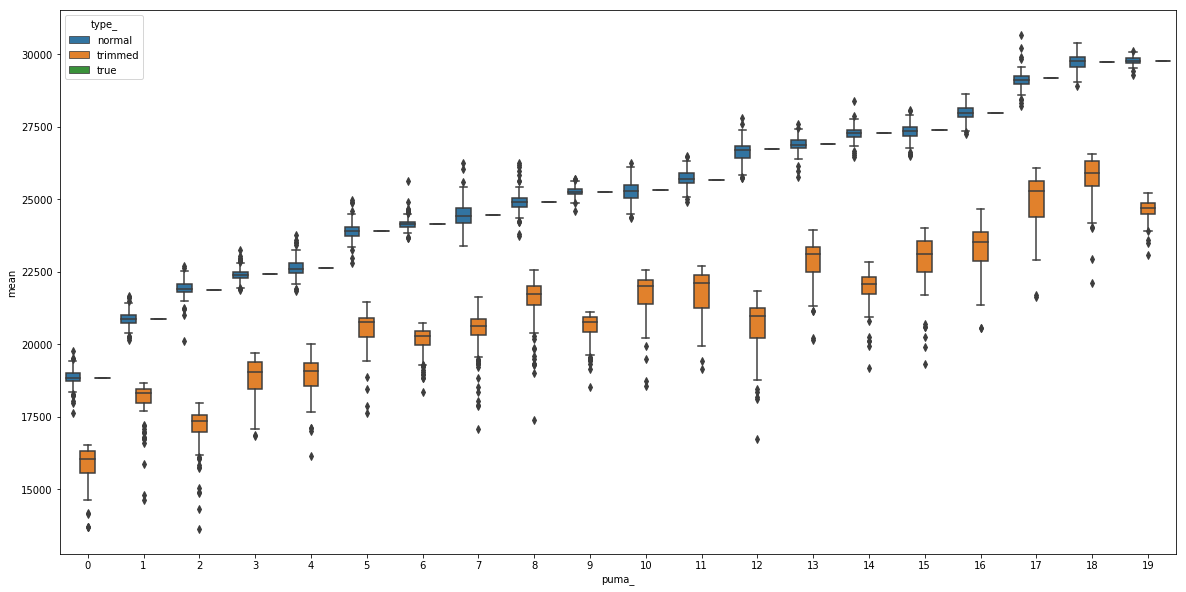

In [636]:
import seaborn as sns
fig = plt.figure(figsize=(20,10))
sns.boxplot(data=results_df,
            hue='type_', x='puma_', y='mean',
           )

We can see that the trimmed estimator consistently underestimates the mean value. (I think this is a bug, but haven't been able to find it). One reason for this is that the $p_{95}$ estimates tend to be conservative (meaningfully below the 95th percentile), perhaps because there are fewer values at the upper end of the distribution.
This in turn leads to sum calculations that omit more than $0.9n$ of the training points, and thus the entire mean is scaled downward.

We can see from the box and whisker plots that the trimming mean tends to have a longer tail in the negative direction.

In theory (and without the bug), this method provides the same level of privacy with a lower level of noise in datasets with a few far-away outliers. This is because we get to scale down the "global sensitivity" by omitting the outliers, which is particularly helpful if most of the dataset is in a much narrower range.

One way to improve utility in this example is that we know in income distributions that the outliers tend to all fall on one side - so shifting our omitted percentiles to be from 90% to 100% (rather than 0-5 and 95-100) would likely increase utility.

## (2)
First, let's reimplement the R code from PSI.

In [637]:
from scipy.special import binom as choose
def computeLHS(eguess, k, eps):
    l = int(np.ceil((eguess + k*eps)/(2*eps)))
    sum_ = 0
    for i in range(l, k):
        sum_ += choose(k, i)*(np.exp(i*eps) - np.exp(eguess + eps*(k-i)))
    return sum_

def KOVhom(params, d_g):
	# Computes the optimal composition theorem for the case when privacy parameters
	# do not differ across statistics. Theorem 3.3 [KOV15]. 
	# 
	# Args:
	#	params: a kx2 matrix where the first column corresponds to epsilon_i values and the second 
	# 			corresponds to delta_i values. 
	#	d_g: global delta value
	#   
	# Returns:
	#	global epsilon value guaranteed from the composition
    k = params.shape[0]
    eps = params[0, 0]
    del_ = params[0, 1]
    eterm = (1 + np.exp(eps))**k
    dterm = (1 - del_)**k
    RHS = eterm*(1 - ((1 - d_g)/dterm))
    u = k*eps
    l = 0
    LHS = np.Inf
    e_g = u
    
	# Must do binary search to approach optimal value
    count = 0
    
	# Completely arbitrary cutoff of 50 rounds. Should have a more principled approach.
    while count < 50:
        eguess = l + ((u - l)/2)
        LHS = computeLHS(eguess, k, eps)
        
		# If eguess satisfies privacy:
        if LHS <= RHS:
            e_g = eguess
            u = eguess
        else:
            l = eguess
        count += 1
    return e_g

In [638]:
def basic_composition(k, e_g, delta):
    e0 = e_g/k
    return e0
def advanced_composition(k, e_g, delta):
    return e_g/np.sqrt(2*k*np.log(1/delta))
tol = 1e-2
def optimal_composition(k, e_g, delta):
    # KOVhom yields e_g given e_0, so need to do binary search over e_0s
    l = 0
    u = 1
    best_error_so_far = np.Inf
    for i in range(100):
        e0guess = l + (u-l)/2
        found_eg = KOVhom(np.array([[e0guess, 0]]*k), delta)
        if np.abs(found_eg - e_g) < tol:
            return e0guess
        elif found_eg > e_g:
            u = e0guess
        else:
            l = e0guess
    raise RuntimeError(f"Ran out of iterations, final e_g was {found_eg}")

In [639]:
e_g = 1
delta = 1e-9
k_range = list(range(10, 100, 2))
e0s_per_k = {
    alg.__name__: np.array([
        alg(k, e_g, delta) for k in tqdm_notebook(k_range)
    ])
    for alg in [basic_composition, advanced_composition, optimal_composition]
}

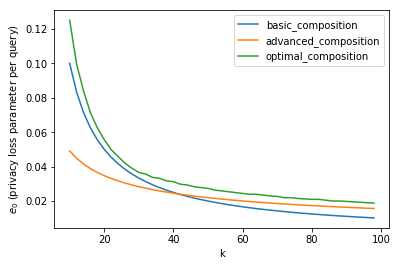

In [640]:
for key, val in e0s_per_k.items():
    plt.plot(k_range, val, label=key)
plt.xlabel("k")
plt.ylabel("$e_0$ (privacy loss parameter per query)")
plt.legend();

After $k>41$ or so, advanced composition improves on basic composition - and optimal composition always strictly improves on basic composition (as we'd hope from some "optimal").

## (3)
Let's write code to implement a 3-D histogram.

In [641]:
df = pd.read_csv("../data/MaPUMS5full.csv")
relevant_axes = ['income', 'educ', 'age']
df = df[relevant_axes]
log_df = df[relevant_axes].copy()
log_df['income'] = np.log(np.clip(df['income'], a_min=1, a_max=np.Inf))
df.describe()

,income,educ,age
count,241830.000000,241830.000000,241830.000000
mean,33762.317041,10.363499,46.245424
std,45767.980716,2.957155,18.152071
min,-10800.000000,1.000000,18.000000
25%,8800.000000,9.000000,32.000000
50%,23000.000000,11.000000,44.000000
75%,42000.000000,13.000000,58.000000
max,832000.000000,16.000000,93.000000


In [653]:
def true_histogram(
    data_raw, upper, lower, nbins=[100, 100, 100]
):
    n, d = data_raw.shape
    data = np.clip(data_raw, lower, upper)
    bins = np.stack([np.linspace(lower[i], upper[i], nbins[i]+1).astype(int)
                     for i in range(d)],
                     axis=0)
    
    hist = np.zeros(nbins)
    hist_val = np.zeros(nbins + [d])
    i_ax = np.zeros([n, d], dtype=int)
    for c in range(d):
        i_ax[:, c] = np.argmin(
            data[:, c].reshape(-1, 1) >= bins[c, 1:],
            axis=1)
    for idx in i_ax:
        hist[tuple(idx.tolist())] +=1
    ax_vals = [(bins[i, 1:] + bins[i, :-1])/2 for i in range(d)]
    hist_vals = np.stack(np.meshgrid(*ax_vals), axis=-1)
    return hist, hist_vals

def sampler(true_hist, hist_vals, epsilon, n, no_dp=False):
    GS = 2
    d = hist_vals.shape[-1]
    hist = true_hist + lap_mechanism(epsilon, GS, size=np.prod(true_hist.shape)).reshape(true_hist.shape)
    if no_dp:
        hist = true_hist
    hist[hist < 0] = 0
    probs = hist.reshape(-1)/hist.sum()
    idxs = np.random.choice(np.prod(true_hist.shape), p=probs, size=n)
    retvals = np.zeros((n, d))
    hv = hist_vals.reshape(-1, d)
    return hv[idxs, :]

We chose $\epsilon = 1$ and forced all the probabilities to be >= 0.

In [654]:
eps = 1

In [655]:
data_true = log_df.values
X_true = data_true[:, 1:]
Y_true = data_true[:, 0]

from sklearn.linear_model import LinearRegression
lr_true = LinearRegression().fit(X_true, Y_true)
lr_coefs_true = np.append(lr_true.coef_, lr_true.intercept_)

In [656]:
true_hist, hist_vals = true_histogram(
    data_true, [6, 16, 100], [0, 1, 0], nbins=[2, 2, 2]
)
samples = 20
lr_coefs_fake = []
for i in tqdm_notebook(range(samples)):
    data_fake = sampler(true_hist, hist_vals, eps, n=df.shape[0])
    X_fake = data_fake[:, 1:]
    Y_fake = data_fake[:, 0]
    lr = LinearRegression().fit(X_fake, Y_fake)
    lr_coefs_fake.append(np.append(lr.coef_, lr.intercept_))
lr_coefs_fake = np.array(lr_coefs_fake)

It appears that something in the histogram calculation is off, but after debugging for hours, I can't find it. Even resampling from the histogram without adding DP noise generates significantly incorrect (though internally-predictable) estimates.

I've run the subsequent analysis regardless, and drawn what takeaways I could.

In [657]:
fake_bias = (lr_coefs_fake - lr_coefs_true).mean(axis=0)**2
fake_var = (lr_coefs_fake - lr_coefs_true).var(axis=0)

print("Estimator bias from fake data: {}".format(fake_bias))
print("Estimator variance from fake data: {}".format(fake_var))

Estimator bias from fake data: [6.43787234e-02 5.90892594e-04 2.47173303e+00]
Estimator variance from fake data: [1.71417375e-05 8.57304146e-09 3.39461147e-04]


Let's compare this setup to a regression trained on subsampled data (10% of the original sample).

In [658]:
frac = 0.1
n = log_df.shape[0]

lr_coefs_subsamp = []
for i in tqdm_notebook(range(samples)):
    data_subsamp = log_df.values[np.random.choice(n, int(n*frac), replace=False), :]
    subsampled_true_hist, hist_vals = true_histogram(
        data_subsamp, [6, 16, 100], [0, 1, 0], nbins=[2, 2, 2]
    )
    data_fake = sampler(true_hist=true_hist, hist_vals=hist_vals, epsilon=1, n=log_df.shape[0], no_dp=True)
    X_fake = data_fake[:, 1:]
    Y_fake = data_fake[:, 0]
    lr = LinearRegression().fit(X_fake, Y_fake)
    lr_coefs_subsamp.append(np.append(lr.coef_, lr.intercept_))
lr_coefs_subsamp = np.array(lr_coefs_subsamp)

In [659]:
subsamp_bias = (lr_coefs_subsamp - lr_coefs_true).mean(axis=0)**2
subsamp_var = (lr_coefs_subsamp - lr_coefs_true).var(axis=0)

print("Estimator bias from subsampled data: {}".format(subsamp_bias))
print("Estimator variance from subsampled data: {}".format(subsamp_var))

Estimator bias from subsampled data: [6.44335693e-02 5.91795079e-04 2.46877215e+00]
Estimator variance from subsampled data: [2.63820762e-05 7.93097233e-09 5.74859704e-04]


So our DP regression and subsampled regression have approximately the same variance in the parameters. Because the bias appears to be so large in both (likely due to a bug in computing the histogram), it's hard to know whether in a "correct" implementation one would be substantially less biased than the other.

It's certainly true that one way to improve the histogram would be to have some notion of perturbation locality - that is, right now, a switch between two adjacent buckets is treated as equally likely to a switch between two buckets that differ maximally on every feature.